In [2]:
from Bio import SeqIO

genome_file = "NC_000913.2.fasta"
genome_file_type = genome_file.split('.')[-1]
record = SeqIO.read(genome_file, genome_file_type)
length = len(record.seq)

## Подготовка данных

In [41]:
import numpy as np

def recode_data():
    bases_dict     = {"A": 0, "T": 1, "C": 2, "G": 3}
    bases_list = ["A", "T", "C", "G"]
    bases_np        = {
                        "A": np.array([1, 0, 0, 0], dtype = np.float32),
                        "T": np.array([0, 1, 0, 0], dtype = np.float32),
                        "C": np.array([0, 0, 1, 0], dtype = np.float32),
                        "G": np.array([0, 0, 0, 1], dtype = np.float32)
                        }

    seq_np = np.zeros((length, 4), dtype = np.float32) 
    for index in range(length):
        base = record.seq[index]
        if base in bases_list:
            channel = bases_dict[base]
            seq_np[index, channel] = 1
        else:
            print("alternative base")
    return seq_np

In [49]:
LENGTH = 10
N_TRAIN = 100000
N_TEST = 10000

def gen_data_sets(seq_np):
    
    train_ids = np.random.choice(int(length * (1-test)) - 300, N_TRAIN, replace=False) + 200
    test_ids = np.random.choice(int(length * test) - 300, N_TEST, replace=False) + int(length * (1-test))

    train1 = np.array([seq_np[x-LENGTH:x, ...] for x in train_ids])
    train2 = np.array([seq_np[x+1:x+LENGTH+1, ...] for x in train_ids])
    train_ans = np.array([seq_np[x, ...]  for x in train_ids])

    test1 = np.array([seq_np[x-LENGTH:x, ...] for x in test_ids])
    test2 = np.array([seq_np[x+1:x+LENGTH+1, ...] for x in test_ids])
    test_ans = np.array([seq_np[x, ...]  for x in test_ids])
    return [train1, train2, train_ans], [test1, test2, test_ans]

In [46]:
seq_np = recode_data()
[train1, train2, train_ans], [test1, test2, test_ans] = gen_data_sets(seq_np)
print(train1.shape, train2.shape, train_ans.shape)
print( test1.shape, test2.shape, test_ans.shape)

100000 222 4175601
10000 4175730 4639365
(100000, 10, 4) (100000, 10, 4) (100000, 4)
(10000, 10, 4) (10000, 10, 4) (10000, 4)


## Самая простая модель - однослойная

In [66]:
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras.layers.normalization import BatchNormalization
from keras.models import Model
    

def create_model():
    x = Input(shape=(10, 4))
    y = Flatten()(x)
    z = Dense(4, activation='softmax')(y)
    model = Model(x, z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 10, 4)             0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 40)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 164       
Total params: 164
Trainable params: 164
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.evaluate(test1, test_ans)

10000/10000 [==============================] - 0s 20us/step


[1.5775941806793212, 0.2344]

In [35]:
model.evaluate(test2, test_ans)

10000/10000 [==============================] - 0s 15us/step


[1.53789299659729, 0.258]

In [38]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', verbose=1, patience=5)
history = model.fit(train1, train_ans, epochs=100, validation_split = 0.1, callbacks = [es])   

Train on 90000 samples, validate on 10000 samples
Epoch 1/100
90000/90000 [==============================] - 2s 25us/step - loss: 1.3595 - acc: 0.3238 - val_loss: 1.3631 - val_acc: 0.3256
Epoch 2/100
90000/90000 [==============================] - 2s 23us/step - loss: 1.3596 - acc: 0.3242 - val_loss: 1.3599 - val_acc: 0.3242
Epoch 3/100
90000/90000 [==============================] - 2s 23us/step - loss: 1.3596 - acc: 0.3237 - val_loss: 1.3605 - val_acc: 0.3258
Epoch 4/100
90000/90000 [==============================] - 2s 24us/step - loss: 1.3596 - acc: 0.3248 - val_loss: 1.3605 - val_acc: 0.3250
Epoch 5/100
90000/90000 [==============================] - 2s 23us/step - loss: 1.3596 - acc: 0.3222 - val_loss: 1.3607 - val_acc: 0.3240
Epoch 6/100
90000/90000 [==============================] - 2s 23us/step - loss: 1.3595 - acc: 0.3237 - val_loss: 1.3614 - val_acc: 0.3261
Epoch 7/100
90000/90000 [==============================] - 2s 23us/step - loss: 1.3596 - acc: 0.3238 - val_loss: 1.3622 - 

In [40]:
model.evaluate(test1, test_ans)

10000/10000 [==============================] - 0s 15us/step


[1.3553408445358277, 0.3328]

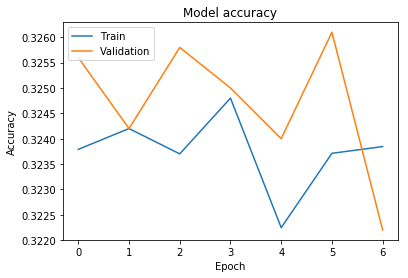

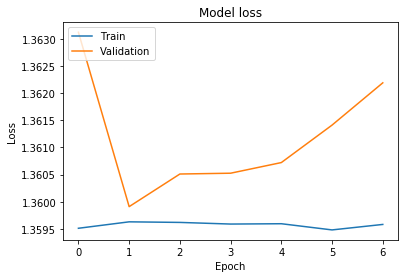

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

проверим, что не переучиваем

0
Epoch 00006: early stopping
Epoch 00008: early stopping
Epoch 00012: early stopping
Epoch 00007: early stopping
Epoch 00007: early stopping
Epoch 00006: early stopping
Epoch 00020: early stopping
Epoch 00006: early stopping
Epoch 00006: early stopping
Epoch 00018: early stopping
10
Epoch 00012: early stopping
Epoch 00006: early stopping
Epoch 00009: early stopping
Epoch 00016: early stopping
Epoch 00011: early stopping
Epoch 00008: early stopping
Epoch 00006: early stopping
Epoch 00006: early stopping
Epoch 00008: early stopping
Epoch 00008: early stopping


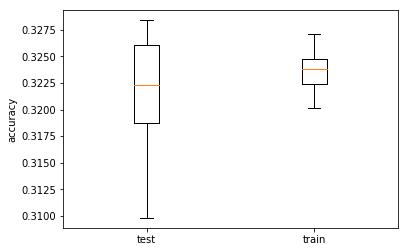

Ks_2sampResult(statistic=0.35000000000000003, pvalue=0.13494714803612687)

In [67]:
seq_np = recode_data()
test_accs_1_1layer = [] 
train_accs_1_1layer = []
for i in range(20):
    if i%10 == 0:
        print(i)
    [train1, train2, train_ans], [test1, test2, test_ans] = gen_data_sets(seq_np)
    history = model.fit(train1, train_ans, epochs=100, validation_split = 0.1, callbacks = [es], verbose=0)   
    acc = model.evaluate(test1, test_ans, verbose=0)[1]
    acc_train = model.evaluate(train1, train_ans, verbose=0)[1]
    test_accs_1_1layer.append(acc)
    train_accs_1_1layer.append(acc_train)

plt.boxplot([test_accs_1_1layer, train_accs_1_1layer])
plt.xticks([1,2], ('test', 'train'))
plt.ylabel("accuracy")
plt.show()
ks_2samp(test_accs_1_1layer, train_accs_1_1layer)

In [50]:
seq_np = recode_data()
test_accs_regr_1 = [] 
for i in range(100):
    if i%10 == 0:
        print(i)
    [train1, train2, train_ans], [test1, test2, test_ans] = gen_data_sets(seq_np)
    history = model.fit(train1, train_ans, epochs=100, validation_split = 0.1, callbacks = [es], verbose=0)   
    acc = model.evaluate(test1, test_ans)[1]
    test_accs_regr_1.append(acc)

0
Epoch 00009: early stopping
10000/10000 [==============================] - 0s 9us/step
Epoch 00006: early stopping
10000/10000 [==============================] - 0s 9us/step
Epoch 00013: early stopping
10000/10000 [==============================] - 0s 9us/step
Epoch 00010: early stopping
10000/10000 [==============================] - 0s 9us/step
Epoch 00010: early stopping
10000/10000 [==============================] - 0s 9us/step
Epoch 00008: early stopping
10000/10000 [==============================] - 0s 9us/step
Epoch 00007: early stopping
10000/10000 [==============================] - 0s 9us/step
Epoch 00014: early stopping
10000/10000 [==============================] - 0s 8us/step
Epoch 00009: early stopping
10000/10000 [==============================] - 0s 8us/step
Epoch 00006: early stopping
10000/10000 [==============================] - 0s 8us/step
10
Epoch 00006: early stopping
10000/10000 [==============================] - 0s 9us/step
Epoch 00012: early stopping
10000/1000

10000/10000 [==============================] - 0s 9us/step
Epoch 00014: early stopping
10000/10000 [==============================] - 0s 8us/step
Epoch 00007: early stopping
10000/10000 [==============================] - 0s 8us/step
Epoch 00007: early stopping
10000/10000 [==============================] - 0s 9us/step
Epoch 00013: early stopping
10000/10000 [==============================] - 0s 10us/step
Epoch 00016: early stopping
10000/10000 [==============================] - 0s 8us/step
Epoch 00014: early stopping
10000/10000 [==============================] - 0s 8us/step


In [52]:
test_accs_regr_2 = [] 
for i in range(100):
    if i%10 == 0:
        print(i)
    [train1, train2, train_ans], [test1, test2, test_ans] = gen_data_sets(seq_np)
    history = model.fit(train2, train_ans, epochs=100, validation_split = 0.1, callbacks = [es], verbose=0)   
    acc = model.evaluate(test2, test_ans)[1]
    test_accs_regr_2.append(acc)

0
Epoch 00007: early stopping
10000/10000 [==============================] - 0s 9us/step
Epoch 00012: early stopping
10000/10000 [==============================] - 0s 9us/step
Epoch 00008: early stopping
10000/10000 [==============================] - 0s 9us/step
Epoch 00012: early stopping
10000/10000 [==============================] - 0s 9us/step
Epoch 00007: early stopping
10000/10000 [==============================] - 0s 9us/step
Epoch 00007: early stopping
10000/10000 [==============================] - 0s 8us/step
Epoch 00007: early stopping
10000/10000 [==============================] - 0s 9us/step
Epoch 00011: early stopping
10000/10000 [==============================] - 0s 9us/step
Epoch 00012: early stopping
10000/10000 [==============================] - 0s 9us/step
Epoch 00008: early stopping
10000/10000 [==============================] - 0s 9us/step
10
Epoch 00010: early stopping
10000/10000 [==============================] - 0s 9us/step
Epoch 00007: early stopping
10000/1000

10000/10000 [==============================] - 0s 8us/step
Epoch 00009: early stopping
10000/10000 [==============================] - 0s 8us/step
Epoch 00006: early stopping
10000/10000 [==============================] - 0s 8us/step
Epoch 00016: early stopping
10000/10000 [==============================] - 0s 9us/step
Epoch 00016: early stopping
10000/10000 [==============================] - 0s 8us/step
Epoch 00007: early stopping
10000/10000 [==============================] - 0s 8us/step
Epoch 00008: early stopping
10000/10000 [==============================] - 0s 9us/step


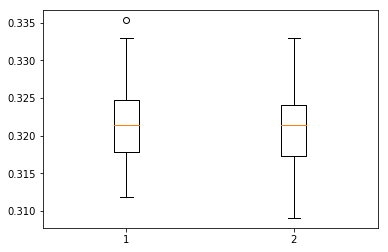

Ks_2sampResult(statistic=0.09000000000000008, pvalue=0.794183771284772)

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import ks_2samp

plt.boxplot([test_accs_regr_1, test_accs_regr_2])
plt.show()
ks_2samp(test_accs_regr_1, test_accs_regr_2)

## Теперь сетка сложнее - два слоя

In [68]:
def create_model():
    x = Input(shape=(10, 4))
    y = Flatten()(x)
    a = Dense(10)(y)
    z = Dense(4, activation='softmax')(a)
    model = Model(x, z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 10, 4)             0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 40)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                410       
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 44        
Total params: 454
Trainable params: 454
Non-trainable params: 0
_________________________________________________________________


In [69]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', verbose=1, patience=4)
history = model.fit(train1, train_ans, epochs=100, validation_split = 0.1, callbacks = [es])   

Train on 90000 samples, validate on 10000 samples
Epoch 1/100
90000/90000 [==============================] - 3s 30us/step - loss: 1.3679 - acc: 0.3123 - val_loss: 1.3603 - val_acc: 0.3145
Epoch 2/100
90000/90000 [==============================] - 2s 25us/step - loss: 1.3605 - acc: 0.3204 - val_loss: 1.3603 - val_acc: 0.3205
Epoch 3/100
90000/90000 [==============================] - 2s 26us/step - loss: 1.3601 - acc: 0.3219 - val_loss: 1.3594 - val_acc: 0.3221
Epoch 4/100
90000/90000 [==============================] - 3s 31us/step - loss: 1.3601 - acc: 0.3215 - val_loss: 1.3609 - val_acc: 0.3178
Epoch 5/100
90000/90000 [==============================] - 2s 26us/step - loss: 1.3599 - acc: 0.3218 - val_loss: 1.3610 - val_acc: 0.3206
Epoch 6/100
90000/90000 [==============================] - 3s 28us/step - loss: 1.3598 - acc: 0.3221 - val_loss: 1.3598 - val_acc: 0.3187
Epoch 7/100
90000/90000 [==============================] - 2s 27us/step - loss: 1.3596 - acc: 0.3217 - val_loss: 1.3594 - 

In [58]:
model.evaluate(test1, test_ans)

10000/10000 [==============================] - 0s 14us/step


[1.3551686933517455, 0.3311]

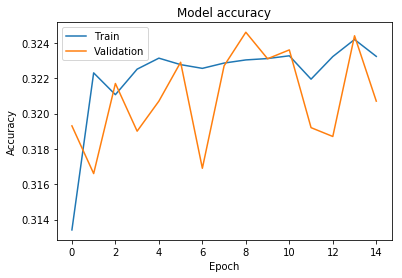

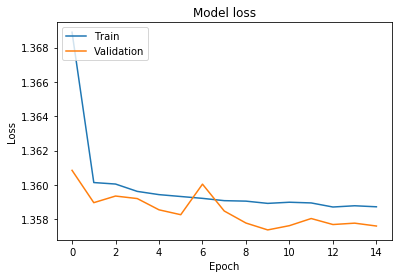

In [59]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Проверим, не переобучается ли

0
Epoch 00005: early stopping
Epoch 00005: early stopping
Epoch 00005: early stopping
Epoch 00006: early stopping
Epoch 00010: early stopping
Epoch 00007: early stopping
Epoch 00005: early stopping
Epoch 00005: early stopping
Epoch 00005: early stopping
Epoch 00009: early stopping
10
Epoch 00009: early stopping
Epoch 00005: early stopping
Epoch 00006: early stopping
Epoch 00009: early stopping
Epoch 00005: early stopping
Epoch 00005: early stopping
Epoch 00007: early stopping
Epoch 00009: early stopping
Epoch 00006: early stopping
Epoch 00005: early stopping


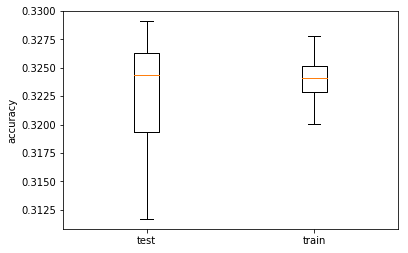

Ks_2sampResult(statistic=0.35, pvalue=0.13494714803612698)

In [71]:
seq_np = recode_data()
test_accs_1_2layer = [] 
train_accs_1_2layer = []
for i in range(20):
    if i%10 == 0:
        print(i)
    [train1, train2, train_ans], [test1, test2, test_ans] = gen_data_sets(seq_np)
    history = model.fit(train1, train_ans, epochs=100, validation_split = 0.1, callbacks = [es], verbose=0)   
    acc = model.evaluate(test1, test_ans, verbose=0)[1]
    acc_train = model.evaluate(train1, train_ans, verbose=0)[1]
    test_accs_1_2layer.append(acc)
    train_accs_1_2layer.append(acc_train)

plt.boxplot([test_accs_1_2layer, train_accs_1_2layer])
plt.xticks([1,2], ('test', 'train'))
plt.ylabel("accuracy")
plt.show()
ks_2samp(test_accs_1_2layer, train_accs_1_2layer)

In [74]:
seq_np = recode_data()
test_accs_regr_1_2layer = [] 
for i in range(100):
    if i%10 == 0:
        print(i)
    [train1, train2, train_ans], [test1, test2, test_ans] = gen_data_sets(seq_np)
    history = model.fit(train1, train_ans, epochs=100, validation_split = 0.1, callbacks = [es], verbose=0)   
    acc = model.evaluate(test1, test_ans, verbose=0)[1]
    test_accs_regr_1_2layer.append(acc)

0
Epoch 00005: early stopping
Epoch 00005: early stopping
Epoch 00007: early stopping
Epoch 00006: early stopping
Epoch 00006: early stopping
Epoch 00012: early stopping
Epoch 00007: early stopping
Epoch 00006: early stopping
Epoch 00005: early stopping
Epoch 00005: early stopping
10
Epoch 00012: early stopping
Epoch 00006: early stopping
Epoch 00005: early stopping
Epoch 00005: early stopping
Epoch 00007: early stopping
Epoch 00007: early stopping
Epoch 00009: early stopping
Epoch 00007: early stopping
Epoch 00010: early stopping
Epoch 00011: early stopping
20
Epoch 00005: early stopping
Epoch 00007: early stopping
Epoch 00011: early stopping
Epoch 00009: early stopping
Epoch 00005: early stopping
Epoch 00005: early stopping
Epoch 00005: early stopping
Epoch 00008: early stopping
Epoch 00010: early stopping
Epoch 00006: early stopping
30
Epoch 00009: early stopping
Epoch 00007: early stopping
Epoch 00012: early stopping
Epoch 00006: early stopping
Epoch 00008: early stopping
Epoch 000

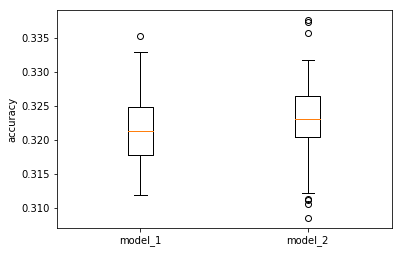

Ks_2sampResult(statistic=0.21000000000000002, pvalue=0.020495314493847068)

In [75]:
plt.boxplot([test_accs_regr_1, test_accs_regr_1_2layer])
plt.xticks([1, 2], ('model_1', 'model_2'))
plt.ylabel("accuracy")
plt.show()
ks_2samp(test_accs_regr_1, test_accs_regr_1_2layer)

(0.31, 0.339)

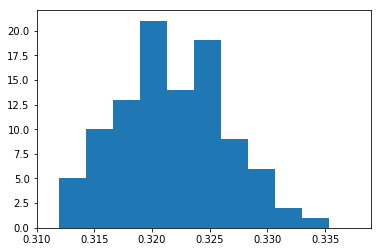

In [78]:
plt.hist(test_accs_regr_1)
plt.xlim(0.31, 0.339)

(0.31, 0.339)

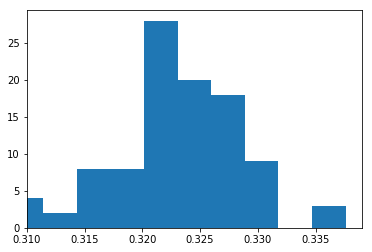

In [79]:
plt.hist(test_accs_regr_1_2layer)
plt.xlim(0.31, 0.339)